In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import re
import pandas as pd

train_dataset = pd.read_csv('./Corona_NLP_train.csv', encoding = "ISO-8859-1")
test_dataset = pd.read_csv('./Corona_NLP_test.csv', encoding = "ISO-8859-1")

to_drop = ['UserName', 'ScreenName', 'Location', 'TweetAt']

train_dataset = train_dataset.drop(columns=to_drop).sample(frac=1, random_state=42) # shuffle rows
test_dataset = test_dataset.drop(columns=to_drop)

def clean_text(text):
    text = text.lower()
    hashtags = "#[\S]+"
    mentions = "@[\S]+"
    url = "https?://[A-z0-9_%/\-\.]+[A-z0-9_\.\-\?&=%]+"
    text = re.sub(url,"",text)
    text = re.sub(hashtags,"",text)
    text = re.sub(mentions,"",text)
    puntuations = "[\.\?!,;:]+"
    text = re.sub(puntuations,"",text)
    return text

map = {
    'Extremely Negative': 0,
    'Negative': 1,
    'Neutral': 2,
    'Positive': 3,
    'Extremely Positive': 4
}

revmap = {
    0: 'Extremely Negative',
    1: 'Negative',
    2: 'Neutral',
    3: 'Positive',
    4: 'Extremely Positive'
}

train_dataset['OriginalTweet'] = train_dataset['OriginalTweet'].apply(lambda x: clean_text(x))
test_dataset['OriginalTweet'] = test_dataset['OriginalTweet'].apply(lambda x: clean_text(x))

train_dataset['Sentiment'] = train_dataset['Sentiment'].apply(lambda x: map[x])
test_dataset['Sentiment'] = test_dataset['Sentiment'].apply(lambda x: map[x])

In [3]:
import torch
from torch import nn
from prettytable import PrettyTable
from transformers import AutoModel, AutoTokenizer
from modules import Encoder, EncoderForSequenceClassification

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

model_name = 'prajjwal1/bert-tiny'
tokenizer = AutoTokenizer.from_pretrained(model_name)
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(sparse_output=False)

class TwitterDataset(Dataset):
    def __init__(self, set) -> None:
        super(TwitterDataset, self).__init__()
        self.input = set['input_ids']
        self.labels = set['labels']
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, index):
        return {
        'input_ids': self.input[index],
        'labels': self.labels[index]
    }

def dset(set):
    tweets = set['OriginalTweet'].to_list()
    tokenized = tokenizer(tweets, return_tensors='pt', padding='max_length', truncation=True, max_length=256)

    return {
        'input_ids': tokenized['input_ids'],
        'labels': ohe.fit_transform(set['Sentiment'].to_numpy().reshape(-1, 1))
    }

train_loader = DataLoader(TwitterDataset(dset(train_dataset)), batch_size=128)
test_loader = DataLoader(TwitterDataset(dset(test_dataset)), batch_size=256)

---
## Тренировка модели

In [5]:
import torch
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from torch.optim import Adam, AdamW, lr_scheduler
from sklearn.metrics import classification_report

def train(model, loader, epochs, lr):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    scheduler = lr_scheduler.CosineAnnealingLR(
        optimizer, 25, 
    )

    model.train()
    
    losses = []
    pbar, step = tqdm(range(len(loader) * epochs)), 0
 
    for epoch in range(epochs):
        for batch in loader:
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            preds = model(inputs)
            loss = criterion(preds, labels)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            losses.append(loss.item())
            pbar.set_description(f'Epoch: {epoch+1}, training loss: {loss.item():0.5f}')#, lr: {scheduler.get_last_lr()[0]:0.5f}')

            step +=1
            pbar.update(1)
        scheduler.step()

    return losses

def evaluate(model, set):
    pred, true = [], []

    model.eval()
    with torch.no_grad():
        for batch in tqdm(set):
            inputs = batch['input_ids'].to(device)
            labels = batch['labels'].to(device)
            preds = model(inputs)
            pred.extend(torch.argmax(preds.cpu(), dim=-1))
            true.extend(torch.argmax(labels.cpu(), dim=-1))
    pred = np.array(pred)
    true = np.array(true)

    return true, pred

In [14]:
classifier = EncoderForSequenceClassification(
    Encoder(tokenizer.vocab_size, 
            num_layers=2,
            attn_heads=4,
            hidden_dim=128,
            dropout=0.2,
            context=256),
    num_classes = 5
).to(device)
count_parameters(classifier)

+---------------------------------------------+------------+
|                   Modules                   | Parameters |
+---------------------------------------------+------------+
|              encoder.te.weight              |  3906816   |
|           encoder.layernorm.weight          |    128     |
|            encoder.layernorm.bias           |    128     |
|        encoder.layers.0.attention.wqs       |   16384    |
|        encoder.layers.0.attention.wks       |   16384    |
|        encoder.layers.0.attention.wvs       |   16384    |
|        encoder.layers.0.attention.wo        |   16384    |
| encoder.layers.0.attention.layernorm.weight |    128     |
|  encoder.layers.0.attention.layernorm.bias  |    128     |
|       encoder.layers.0.linear1.weight       |   16384    |
|        encoder.layers.0.linear1.bias        |    128     |
|       encoder.layers.0.linear2.weight       |   16384    |
|        encoder.layers.0.linear2.bias        |    128     |
|      encoder.layers.0.

4105861

In [7]:
true, pred = evaluate(classifier, test_loader)
print(classification_report(true, pred))

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       592
           1       0.00      0.00      0.00      1041
           2       0.17      0.70      0.27       619
           3       0.27      0.33      0.30       947
           4       0.00      0.00      0.00       599

    accuracy                           0.20      3798
   macro avg       0.09      0.21      0.11      3798
weighted avg       0.09      0.20      0.12      3798



In [15]:
from sklearn.metrics import f1_score
true, pred = evaluate(classifier, test_loader)
print(f1_score(true, pred, average='weighted'))

  0%|          | 0/15 [00:00<?, ?it/s]

0.1975334185035455


In [8]:
losses = train(classifier, train_loader, epochs=50, lr=1e-3)

  0%|          | 0/16100 [00:00<?, ?it/s]

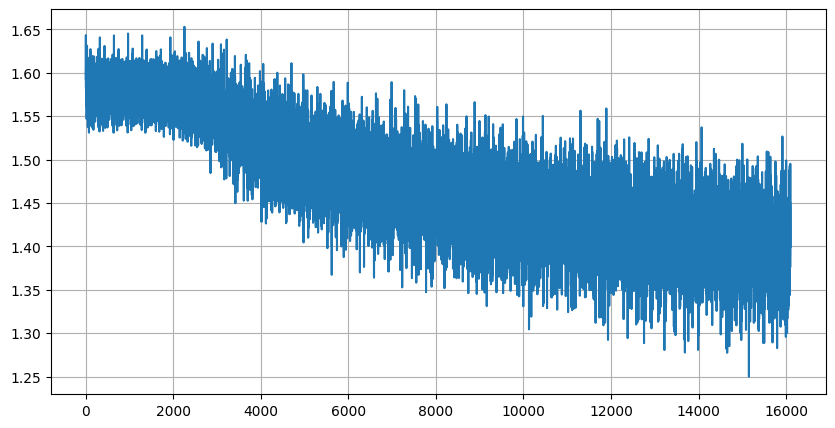

In [9]:
fig = plt.figure(figsize=(10, 5))
plt.plot(torch.arange(len(losses)), losses)
plt.grid()
plt.show()

In [10]:
true, pred = evaluate(classifier, test_loader)
print(classification_report(true, pred))

  0%|          | 0/15 [00:00<?, ?it/s]

              precision    recall  f1-score   support

           0       0.18      0.05      0.08       592
           1       0.28      0.34      0.31      1041
           2       0.15      0.11      0.12       619
           3       0.26      0.37      0.31       947
           4       0.15      0.15      0.15       599

    accuracy                           0.23      3798
   macro avg       0.20      0.20      0.19      3798
weighted avg       0.22      0.23      0.22      3798



In [13]:
from sklearn.metrics import f1_score
true, pred = evaluate(classifier, test_loader)
print(f1_score(true, pred, average='weighted'))

  0%|          | 0/15 [00:00<?, ?it/s]

0.21781690274047727


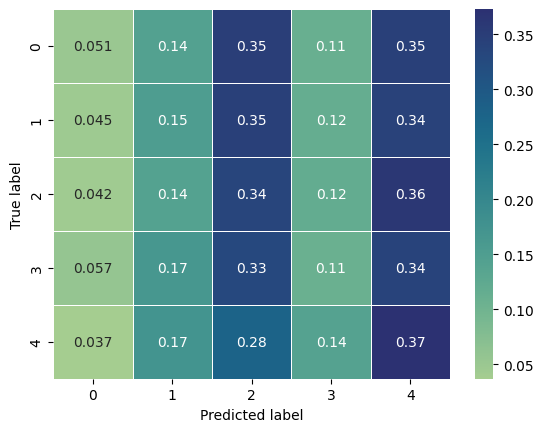

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
conf_mat = confusion_matrix([revmap[x] for x in true], [revmap[x] for x in pred])
conf_mat_normalized = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
sns.heatmap(conf_mat_normalized, annot=True, linewidth=.5, cmap="crest")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()